<a href="https://colab.research.google.com/github/romerocruzsa/cp-anemia-detection/blob/notebook-upload/Anemia_MobileNet_BaseVsQAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning on MobileNetV2 for Anemia Detection and Hemoglobin Estimation

**Author**: [Sebastián A. Cruz Romero](https://github.com/romerocruzsa/)

**Reviewed by**:

This tutorial builds on [CP-Anemic Paper]() paper. Transfer learning refers to methods that leverage pretrained models in different applications and datasets. This tutorial replicates the methodology for implementing Deep Learning architectures for Anemia Detection and Hemoglobin estimation through *Conjutiva pallor* analysis. Warning: we use a lot of boilerplate code from other PyTorch repos to, for example, define the [MobileNetV2](https://arxiv.org/abs/1801.04381) model architecture, define data loaders, and so on.

## Installing Dependencies and Pre-Requisites

In [1]:
# !yes y | pip uninstall torch torchvision
# !yes y | pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
# # Install other dependencies
# !yes y | pip install torchinfo
# !yes y | pip install torchmetrics

In [2]:
# Import necessary libraries for file handling, data manipulation, and visualization
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for working with images and transformations
from PIL import Image
import cv2 as cv

# Import PyTorch modules for model building, data handling, and evaluation
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.models.quantization as quant_models
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

# Import libraries for machine learning metrics and model evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error, r2_score
import torchmetrics
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Set the seed.
seed = 42
torch.manual_seed(seed)

## CP-AnemiC: A *conjunctival pallor* dataset and benchmark for anemia detection in children

Anemia is a universal public health issue, which occurs as the result of a reduction in red blood cells. Early detection of anemia in children is highly desirable for effective treatment measures. We train and test our quantizable MobileNetV2 architecture to detect anemia on [CP-AnemiC](https://www.sciencedirect.com/science/article/pii/S2590093523000395), comprising 710 individuals (range of age, 6–59 months), gathered from several hospitals in Ghana. The conjunctiva image-based dataset is supported with Hb levels (g/dL) annotations for accurate diagnosis of anemia.

In [3]:
data_dir="/home/sebastian-cruz6/workspace/cp-anemia-detection/data/cp-anemia/"
weights_dir="/home/sebastian-cruz6/workspace/cp-anemia-detection/notebooks/weights"
anemic_dir=data_dir+"/Anemic"
non_anemic_dir=data_dir+"/Non-anemic"
signature = "11062024"

In [4]:
# data_dir = "/home/sebastian-cruz6/workspace/model-compression/data/cp-anemia/"
# weights_dir = "/home/sebastian-cruz6/workspace/model-compression/models/weights/"
# anemic_dir = data_dir+"Anemic/"
# non_anemic_dir = data_dir+"Non-anemic/"

data_sheet_path = data_dir+"Anemia_Data_Collection_Sheet.csv"
data_sheet = pd.read_csv(data_sheet_path)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana
...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana


In [5]:
# Mapping diagnosis to severity
severity_mapping = {
    "Non-Anemic": [1,0,0,0],
    "Mild": [0,1,0,0],
    "Moderate": [0,0,1,0],
    "Severe": [0,0,0,1],
}
# Mapping diagnosis to severity
remark_mapping = {
    "Non-anemic": 0,
    "Anemic": 1
}

data_sheet['SEVERITY_ONEHOT'] = data_sheet['Severity'].map(severity_mapping)
data_sheet['REMARK_ONEHOT'] = data_sheet['REMARK'].map(remark_mapping)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT,REMARK_ONEHOT
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana,"[0, 0, 1, 0]",1
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana,"[0, 0, 1, 0]",1
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana,"[0, 0, 1, 0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]",0
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0


### Loading Data

We will use `torchvision` and `torch.utils.data` packages to load the data. The problem we are trying to solve today is classifying images of the inner-part of the eyelid between Anemic and Non-anemic patients. The dataset contains about 710 images of which we will do an 80/20 split between training and testing subset. After that, we perform 5-fold cross-validation with our training set to avoid overfitting on smaller dataset. Since we are using transfer learning, we should be able to generalize reasonably well.

In [6]:
# # BATCH_SIZE = 4
# # test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# for img, binary_label, multiclass_label, hb_level, descriptor in test_loader:
#   print(binary_label, multiclass_label, hb_level, descriptor)
#   break

In [7]:
# Define data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomHorizontalFlip(p=np.random.rand()),
    transforms.RandomVerticalFlip(p=np.random.rand()),
    transforms.RandomRotation(degrees=np.random.randint(0, 360)),
    transforms.RandomAffine(degrees=np.random.randint(0, 360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CPAnemiCDataset(Dataset):
    def __init__(self, dir, df, transform=None):
        self.dir = dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['IMAGE_ID']
        img_folder = row['REMARK']
        img_path = os.path.join(self.dir, img_folder, img_id + ".png")
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        binary_label = torch.tensor(row['REMARK_ONEHOT'], dtype=torch.float32)  # Adjusted for BCEWithLogitsLoss
        multiclass_label = torch.tensor(row['SEVERITY_ONEHOT'], dtype=torch.float32)
        hb_level = torch.tensor(row['HB_LEVEL'], dtype=torch.float32)
        descriptor = row['REMARK']+"/"+row['Severity']

        return img, binary_label, multiclass_label, hb_level, descriptor

    # Load the dataset
image_dataset = CPAnemiCDataset(data_dir, data_sheet, transform=transform)
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.20, shuffle=True)

print(f"Image Dataset Size (All): {len(image_dataset)}, \
        Train Size: {len(train_dataset)}, \
        Test Size: {len(test_dataset)}")

BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Image Dataset Size (All): 710,         Train Size: 568,         Test Size: 142


In [8]:
# Default device
device = torch.device('cpu')

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA is not available, using CPU.")

print(f"Selected device: {device}")

Selected device: cuda


## Helper functions

We define several helper functions to help with model evaluation, understanding our predicitve performance, and visualizing our results.

### Performance Metrics and Model Evalution

In [9]:
import torch
import torchmetrics
import numpy as np
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

class CumulativeMetrics:
    def __init__(self, model_type="binary", num_classes=1, device="cpu"):
        self.model_type = model_type
        self.num_classes = num_classes
        self.device = device
        self.reset()

        # Classification metrics initialization
        if model_type == "binary":
            self.accuracy = torchmetrics.Accuracy(task="binary").to(device)
            self.precision = torchmetrics.Precision(task="binary").to(device)
            self.recall = torchmetrics.Recall(task="binary").to(device)
            self.f1_score = torchmetrics.F1Score(task="binary").to(device)

    def reset(self):
        self.num_batches = 0
        # Cumulative sums for each metric
        self.cum_acc = 0.0
        self.cum_prec = 0.0
        self.cum_rec = 0.0
        self.cum_f1 = 0.0
        self.cum_mse = 0.0
        self.cum_mae = 0.0
        self.cum_r2 = 0.0
        # Storage for AUC
        self.y_true_all = []
        self.y_score_all = []

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        if self.model_type == "binary":
            y_pred_class = torch.round(torch.sigmoid(y_pred)).int()
            self.y_true_all.extend(y_true.detach().cpu().numpy().tolist())
            self.y_score_all.extend(torch.sigmoid(y_pred).detach().cpu().numpy().tolist())

            # Update binary classification metrics
            self.cum_acc += self.accuracy(y_pred_class, y_true).item()
            self.cum_prec += self.precision(y_pred_class, y_true).item()
            self.cum_rec += self.recall(y_pred_class, y_true).item()
            self.cum_f1 += self.f1_score(y_pred_class, y_true).item()

        elif self.model_type == "regression":
            y_true_np = y_true.detach().cpu().numpy()
            y_pred_np = y_pred.detach().cpu().numpy()
            self.y_true_all.extend(y_true_np.tolist())
            self.y_score_all.extend(y_pred_np.tolist())

            # Compute per-batch regression metrics
            self.cum_mse += mean_squared_error(y_true_np, y_pred_np)
            self.cum_mae += mean_absolute_error(y_true_np, y_pred_np)
            self.cum_r2 += r2_score(y_true_np, y_pred_np)

        self.num_batches += 1

    def compute(self):
        if self.model_type == "binary":
            return {
                "Accuracy": self.cum_acc / self.num_batches,
                "Precision": self.cum_prec / self.num_batches,
                "Recall": self.cum_rec / self.num_batches,
                "F1 Score": self.cum_f1 / self.num_batches,
                "AUC Score": roc_auc_score(self.y_true_all, self.y_score_all)
            }

        elif self.model_type == "regression":
            return {
                "Mean Squared Error": self.cum_mse / self.num_batches,
                "Mean Absolute Error": self.cum_mae / self.num_batches,
                "R2 Score": self.cum_r2 / self.num_batches,
            }

## Model Training and Evaluation

Below is a generic function for model training. This function also

* Calculates model performance metrics (Loss, Accuracy, Precision, F1 Score, etc.)
* Saves the best model per highest F1 Score during the validation fold
* Switches between `Validation` and `Test` phases

In [10]:
def train(dataloader, model, loss_fn, optimizer, cumulative_metrics, task_type="binary"):
    model.train()
    cumulative_metrics.reset()
    batch_losses = []

    for _, (img, binary, multiclass, hb_level, _) in enumerate(dataloader):
        img = img.to(device)
        binary = binary.to(device).unsqueeze(1).float()
        multiclass = multiclass.to(device)
        hb_level = hb_level.to(device).unsqueeze(1).float()

        optimizer.zero_grad()

        # Forward pass and loss calculation based on task type
        if task_type == "binary":
            pred = model(img)
            loss = loss_fn(pred, binary)  # Binary target
        elif task_type == "regression":
            pred = model(img)  # Direct prediction for regression
            loss = loss_fn(pred, hb_level)  # Regression target
        else:
            raise ValueError("Unsupported task type. Choose 'binary' or 'regression'.")
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        cumulative_metrics.update(pred, binary if task_type == "binary" else hb_level)

    avg_loss = sum(batch_losses) / len(batch_losses)
    performance_metrics = cumulative_metrics.compute()

    return avg_loss, performance_metrics


def eval(dataloader, model, loss_fn, mode, cumulative_metrics, task_type="binary"):
    model.eval()
    cumulative_metrics.reset()
    batch_losses = []

    with torch.no_grad():
        for _, (img, binary, multiclass, hb_level, _) in enumerate(dataloader):
            img = img.to(device)
            binary = binary.to(device).unsqueeze(1).float()
            multiclass = multiclass.to(device)
            hb_level = hb_level.to(device).unsqueeze(1).float()

            # Forward pass and loss calculation based on task type
            if task_type == "binary":
                pred = model(img)
                loss = loss_fn(pred, binary)  # Binary target
            elif task_type == "regression":
                pred = model(img)  # Direct prediction for regression
                loss = loss_fn(pred, hb_level)  # Regression target
            else:
                raise ValueError("Unsupported task type. Choose 'binary' or 'regression'.")

            batch_losses.append(loss.item())
            cumulative_metrics.update(pred, binary if task_type == "binary" else hb_level)

    avg_loss = sum(batch_losses) / len(batch_losses)
    performance_metrics = cumulative_metrics.compute()

    return avg_loss, performance_metrics

More support functions to:

* Get model size in MB
* Plot phase accuracy and loss
* Visualize our model predictions
* Load the `MobileNetV2` in its base and quantizable form

*Note that we do modifications in the last sequential layer to adjust for the classes to be predicted.*

In [11]:
def get_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    model_size = "Model Size: %.2f MB" %(os.path.getsize("tmp.pt")/1e6)
    os.remove('tmp.pt')
    return model_size

def plot_metrics(metrics_df, phase, model):
    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    loss_df = metrics_df["Loss"]
    ax[0].plot(range(len(loss_df)), loss_df, linestyle='-', color='blue')
    ax[0].set_title(f"{phase} Loss with {model} on CP-AnemiC Dataset")
    ax[0].set_xlabel("Folds")
    ax[0].set_ylabel("Cross-Entropy Loss")
    ax[0].grid(True)

    # Plot Accuracy
    acc_df = metrics_df["Accuracy"]
    ax[1].plot(range(len(acc_df)), acc_df, linestyle='-', color='green')
    ax[1].set_title(f"{phase} Accuracy with {model} on CP-AnemiC Dataset")
    ax[1].set_xlabel("Folds")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid(True)

    # Adjust layout to prevent overlap and display the plots
    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataloader, rows=5, cols=5, device='cpu'):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader.dataset)

    # Get a batch of images from the dataloader
    X, y, descriptors = next(iter(dataloader))
    inputs = X.to(device)
    labels = y.to(device)

    # Run the inputs through the model
    with torch.no_grad():
        pred = (torch.sigmoid(model(X)) >= 0.5).float()
        pred = pred.to(device)

        # Create a grid of images with their predictions
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle('Model Predictions', fontsize=12)

        # Loop through the grid and plot images
        for i in range(rows * cols):
            if i >= len(inputs):
                break

            ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
            img = inputs[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean  # Unnormalize the image
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.axis('off')
            pred_label = pred[i].item()
            true_label = labels[i].item()
            ax.set_title(f'Pred: {pred_label} | True: {true_label}', fontsize=10)

        plt.tight_layout()
        plt.show()

def load_mobilenet():
#     model_quantized = quant_models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT", quantize=False)
    model = models.mobilenet_v2(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(num_ftrs, 1)  # Adjust based on your number of classes
    )

    model = model.to(device)
    return model

## Transfer Learning with MobileNetV2

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

* Depthwise separable convolutions
* Thin input and output bottlenecks between layers
* Shortcut connections between bottleneck layers

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps:

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

1. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: Shape of the depthwise convolution X Number of filters.

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information.

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers.


In [12]:
model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
model = model.to(device)
print(summary(model))

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model.

**What you should remember:**

MobileNetV2's unique features are:
* Depthwise separable convolutions that provide lightweight feature filtering and creation
* Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

In [13]:
# %%time

# # Training parameters
# task_type = "regression"  # Choose from "binary", "multiclass", "regression"
# BATCH_SIZE = 32
# EPOCHS = 150
# FOLDS = 5

# # Assuming CumulativeMetrics is implemented elsewhere and is compatible with task_type
# cumulative_metrics = CumulativeMetrics(model_type=task_type, device=device)  # Instantiate metrics tracker

# # 5-fold cross-validation setup
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# # Initialize model, loss function, and optimizer
# model = load_mobilenet()  # Your MobileNetV2 instance
# loss_fn = torch.nn.BCEWithLogitsLoss() if task_type == "binary" else torch.nn.MSELoss()  # Select appropriate loss
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# # Directory to save the model with the best performance metrics
# os.makedirs(weights_dir, exist_ok=True)

# best_val_score = -float('inf') if task_type == "binary" else -float('inf')
# train_metrics_df = []
# val_metrics_df = []

# for epoch in range(EPOCHS):
#     print(f"\nEpoch {epoch+1}/{EPOCHS}")
#     fold = 1
#     fold_best_train_f1score = float('inf') if task_type == "binary" else -float('inf')

#     for train_idx, val_idx in kf.split(train_dataset):
#         train_subset = Subset(image_dataset, train_idx)
#         val_subset = Subset(image_dataset, val_idx)

#         train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
#         val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

#         if fold == FOLDS:
#             # Validation loop
#             avg_val_loss, val_metrics = eval(val_loader, model, loss_fn, mode="Validation",
#                                              cumulative_metrics=cumulative_metrics, task_type=task_type)

#             if task_type == "binary":
#                 # Unpack classification metrics
#                 avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = val_metrics.values()
#                 print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}, "
#                       f"Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, AUC Score: {avg_val_auc:.4f}")

#                 # Save model with the best validation F1 score
#                 if avg_val_f1 > best_val_score:
#                     best_val_score = avg_val_f1
#                     val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
#                     val_metrics_df.append(val_metrics_dict)
#                     torch.save(model.state_dict(), f'{weights_dir}/model_best_f1score_{task_type}_{signature}.pth')
#                     print(f"Model with best F1 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

#             elif task_type == "regression":
#                 # Unpack regression metrics
#                 avg_val_mse, avg_val_mae, avg_val_r2 = val_metrics.values()
#                 print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, MSE: {avg_val_mse:.4f}, "
#                       f"MAE: {avg_val_mae:.4f}, R2 Score: {avg_val_r2:.4f}")

#                 # Save model with best R2 score
#                 if avg_val_r2 > best_val_score:
#                     best_val_score = avg_val_r2
#                     val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
#                     val_metrics_df.append(val_metrics_dict)
#                     torch.save(model.state_dict(), f'{weights_dir}/model_best_r2score_{task_type}_{signature}.pth')
#                     print(f"Model with best R2 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

#         else:
#             # Training loop
#             avg_train_loss, train_metrics = train(train_loader, model, loss_fn, optimizer, cumulative_metrics, task_type=task_type)

#             if task_type == "binary":
#                 # Unpack classification metrics
#                 avg_train_accuracy, avg_train_precision, avg_train_recall, avg_train_f1, avg_train_auc = train_metrics.values()
#                 print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, "
#                       f"Precision: {avg_train_precision:.4f}, Recall: {avg_train_recall:.4f}, F1 Score: {avg_train_f1:.4f}, AUC Score: {avg_train_auc:.4f}")
#                 train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
#                 train_metrics_df.append(train_metrics_dict)

#             elif task_type == "regression":
#                 # Unpack regression metrics
#                 avg_train_mse, avg_train_mae, avg_train_r2 = train_metrics.values()
#                 print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, MSE: {avg_train_mse:.4f}, "
#                       f"MAE: {avg_train_mae:.4f}, R2: {avg_train_r2:.4f}")
#                 train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
#                 train_metrics_df.append(train_metrics_dict)

#         # Reset metrics and prepare for the next fold
#         cumulative_metrics.reset()
#         fold += 1

# print(get_model_size(model))

We can now evaluate how our model performed on our regression task (hemoglobin estimation)

In [14]:
# %%time

# model.load_state_dict(torch.load(f"{weights_dir}/model_best_r2score_regression_11062024.pth"))
# test_loss, test_performance_metrics = eval(test_loader, model, loss_fn, 'Testing', CumulativeMetrics(model_type="regression", device=device))
# test_mse, test_mae, test_r2 = test_performance_metrics.values()
# print(f"Testing: \tLoss: {test_loss:.4f}, MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R2 Score: {test_r2:.4f}")

In [15]:
%%time

# Training parameters
task_type = "binary"  # Choose from "binary", "multiclass", "regression"
BATCH_SIZE = 32
EPOCHS = 150
FOLDS = 5

# Assuming CumulativeMetrics is implemented elsewhere and is compatible with task_type
cumulative_metrics = CumulativeMetrics(model_type=task_type, device=device)  # Instantiate metrics tracker

# 5-fold cross-validation setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Initialize model, loss function, and optimizer
model = load_mobilenet()  # Your MobileNetV2 instance
loss_fn = torch.nn.BCEWithLogitsLoss() if task_type == "binary" else torch.nn.MSELoss()  # Select appropriate loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Directory to save the model with the best performance metrics
os.makedirs(weights_dir, exist_ok=True)

best_val_score = -float('inf') if task_type == "binary" else -float('inf')
train_metrics_df = []
val_metrics_df = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    fold = 1
    fold_best_train_f1score = float('inf') if task_type == "binary" else -float('inf')

    for train_idx, val_idx in kf.split(train_dataset):
        train_subset = Subset(image_dataset, train_idx)
        val_subset = Subset(image_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        if fold == FOLDS:
            # Validation loop
            avg_val_loss, val_metrics = eval(val_loader, model, loss_fn, mode="Validation",
                                             cumulative_metrics=cumulative_metrics, task_type=task_type)

            if task_type == "binary":
                # Unpack classification metrics
                avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = val_metrics.values()
                print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}, "
                      f"Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, AUC Score: {avg_val_auc:.4f}")

                # Save model with the best validation F1 score
                if avg_val_f1 > best_val_score:
                    best_val_score = avg_val_f1
                    val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
                    val_metrics_df.append(val_metrics_dict)
                    torch.save(model.state_dict(), f'{weights_dir}/model_best_f1score_{task_type}_{signature}.pth')
                    print(f"Model with best F1 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

            elif task_type == "regression":
                # Unpack regression metrics
                avg_val_mse, avg_val_mae, avg_val_r2 = val_metrics.values()
                print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, MSE: {avg_val_mse:.4f}, "
                      f"MAE: {avg_val_mae:.4f}, R2 Score: {avg_val_r2:.4f}")

                # Save model with best R2 score
                if avg_val_r2 > best_val_score:
                    best_val_score = avg_val_r2
                    val_metrics_dict = {**{"Loss": avg_val_loss}, **val_metrics}
                    val_metrics_df.append(val_metrics_dict)
                    torch.save(model.state_dict(), f'{weights_dir}/model_best_r2score_{task_type}_{signature}.pth')
                    print(f"Model with best R2 Score of {best_val_score:.4f} saved at epoch {epoch + 1}")

        else:
            # Training loop
            avg_train_loss, train_metrics = train(train_loader, model, loss_fn, optimizer, cumulative_metrics, task_type=task_type)

            if task_type == "binary":
                # Unpack classification metrics
                avg_train_accuracy, avg_train_precision, avg_train_recall, avg_train_f1, avg_train_auc = train_metrics.values()
                print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, "
                      f"Precision: {avg_train_precision:.4f}, Recall: {avg_train_recall:.4f}, F1 Score: {avg_train_f1:.4f}, AUC Score: {avg_train_auc:.4f}")
                train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
                train_metrics_df.append(train_metrics_dict)

            elif task_type == "regression":
                # Unpack regression metrics
                avg_train_mse, avg_train_mae, avg_train_r2 = train_metrics.values()
                print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, MSE: {avg_train_mse:.4f}, "
                      f"MAE: {avg_train_mae:.4f}, R2: {avg_train_r2:.4f}")
                train_metrics_dict = {**{"Loss": avg_train_loss}, **train_metrics}
                train_metrics_df.append(train_metrics_dict)

        # Reset metrics and prepare for the next fold
        cumulative_metrics.reset()
        fold += 1

print(get_model_size(model))


Epoch 1/150
Training: 	Fold 1 - Loss: 0.6911, Accuracy: 0.5174, Precision: 0.5693, Recall: 0.6185, F1 Score: 0.5759, AUC Score: 0.5223
Training: 	Fold 2 - Loss: 0.6404, Accuracy: 0.6590, Precision: 0.6809, Recall: 0.8426, F1 Score: 0.7507, AUC Score: 0.6353
Training: 	Fold 3 - Loss: 0.6208, Accuracy: 0.6618, Precision: 0.6901, Recall: 0.8290, F1 Score: 0.7454, AUC Score: 0.6711
Training: 	Fold 4 - Loss: 0.5842, Accuracy: 0.7134, Precision: 0.7027, Recall: 0.8922, F1 Score: 0.7823, AUC Score: 0.7290

Validation: 	Fold 5 - Loss: 0.5351, Accuracy: 0.6990, Precision: 0.7182, Recall: 0.8346, F1 Score: 0.7583, AUC Score: 0.8054
Model with best F1 Score of 0.7583 saved at epoch 1

Epoch 2/150
Training: 	Fold 1 - Loss: 0.5748, Accuracy: 0.7083, Precision: 0.7082, Recall: 0.8460, F1 Score: 0.7682, AUC Score: 0.7450
Training: 	Fold 2 - Loss: 0.5377, Accuracy: 0.7215, Precision: 0.7656, Recall: 0.7889, F1 Score: 0.7719, AUC Score: 0.8004
Training: 	Fold 3 - Loss: 0.5419, Accuracy: 0.7257, Precis

We can now evaluate our models performance using a test set on a single batch

In [21]:
%%time

model.load_state_dict(torch.load(f"{weights_dir}/model_best_f1score_binary_11062024.pth"))
test_loss, test_performance_metrics = eval(test_loader, model, loss_fn, 'Testing', CumulativeMetrics(model_type="binary", device=device))
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_performance_metrics.values()
print(f"Testing: \tLoss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AUC Score: {test_auc:.4f}")

Testing: 	Loss: 0.1945, Accuracy: 0.9357, Precision: 1.0000, Recall: 0.8917, F1 Score: 0.9424, AUC Score: 0.9774
CPU times: user 973 ms, sys: 108 ms, total: 1.08 s
Wall time: 73.3 ms


In [17]:
train_metrics_df = pd.DataFrame(train_metrics_df)
display(train_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC Score
587,0.007728,1.000000,1.000000,1.000000,1.000000,1.000000
575,0.011898,1.000000,1.000000,1.000000,1.000000,1.000000
263,0.014912,1.000000,1.000000,1.000000,1.000000,1.000000
409,0.019889,1.000000,1.000000,1.000000,1.000000,1.000000
586,0.006042,0.997917,0.997436,1.000000,0.998693,1.000000
518,0.012925,0.997917,0.996491,1.000000,0.998198,1.000000
572,0.013439,0.997917,0.996078,1.000000,0.997980,0.999941
574,0.016545,0.997917,0.996970,1.000000,0.998450,1.000000
588,0.011305,0.997917,0.995833,1.000000,0.997849,0.999941
490,0.010916,0.997917,1.000000,0.996491,0.998198,1.000000


In [18]:
val_metrics_df = pd.DataFrame(val_metrics_df)
display(val_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC Score
8,0.037500,1.000000,1.000000,1.000000,1.000000,1.000000
7,0.061978,0.984375,0.989130,0.986111,0.987302,0.999359
6,0.086807,0.976562,0.975242,0.986111,0.980556,0.996795
5,0.127355,0.953125,0.966063,0.941628,0.953527,0.989744
4,0.239747,0.914982,0.951389,0.890200,0.919448,0.969231
3,0.302384,0.867188,0.928571,0.818570,0.864461,0.947756
2,0.364483,0.843750,0.851389,0.857712,0.853175,0.914744
1,0.478632,0.729320,0.695040,0.905692,0.784420,0.869231
0,0.535081,0.698989,0.718155,0.834645,0.758268,0.805449


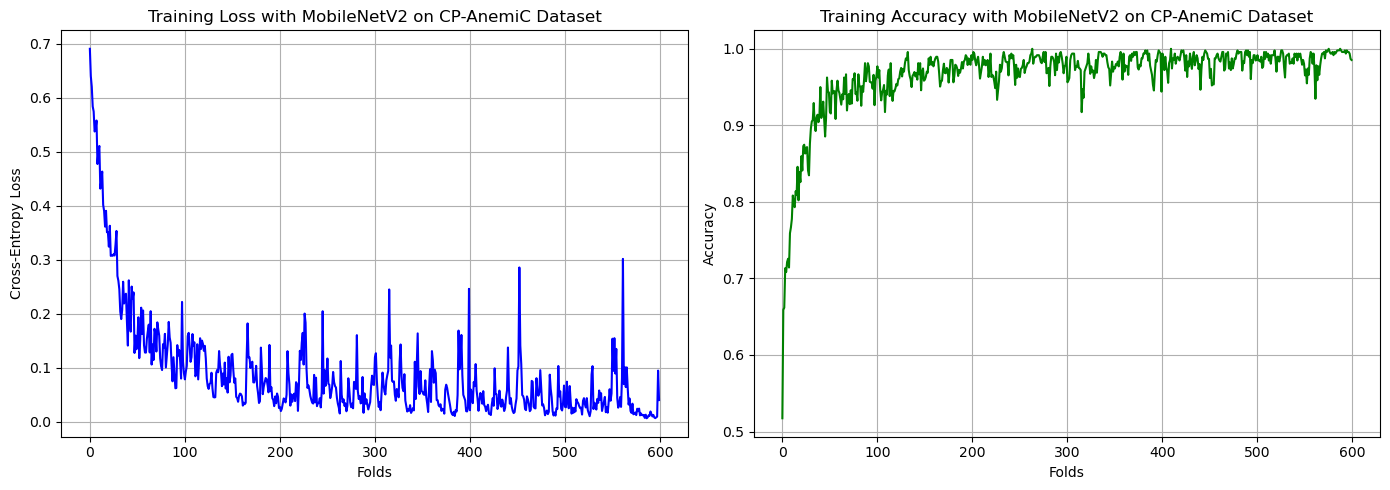

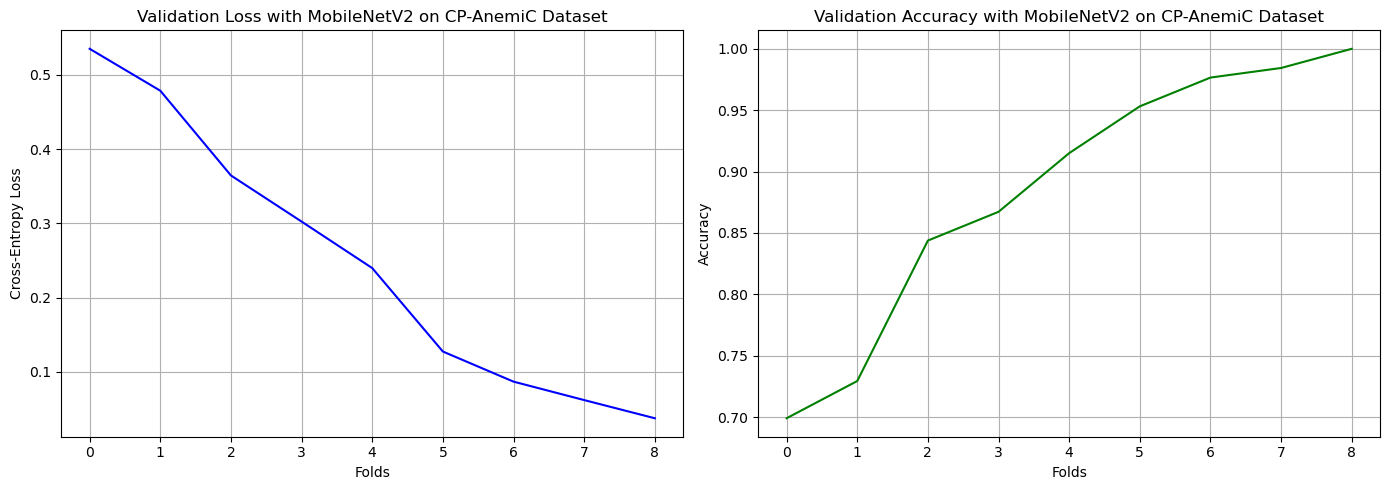

In [19]:
model_name = f"MobileNetV2"#, {get_model_size(model)}"
plot_metrics(train_metrics_df, "Training", model_name)
plot_metrics(val_metrics_df, "Validation", model_name)